In [1]:
from IMPA.dataset.data_loader import CellDataLoader
from IMPA.solver import IMPAmodule
from omegaconf import OmegaConf
from tqdm import tqdm
import matplotlib.pyplot as plt
from pathlib import Path
import numpy as np
import pandas as pd
import os
import torch
import yaml 
import scanpy as sc
import seaborn as sns

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


In [2]:
class Args:
    def __init__(self, dictionary):
        self.__dict__ = dictionary

    def __getattr__(self, key):
        if key in self.__dict__:
            return self.__dict__[key]
        else:
            raise AttributeError(f"'DictToObject' object has no attribute '{key}'")

    def __call__(self, key):
        return self.__getattr__(key)

def t2np(t):
    return ((t.permute(0,2, 3, 1) + 1) / 2).clamp(0,1).cpu().numpy()

In [3]:
with open("/home/icb/alessandro.palma/environment/IMPA/IMPA/config_hydra/config/cpg0000_multimodal_leaveout.yaml", "rb") as file:
    config_dict = yaml.safe_load(file)
    
args = OmegaConf.create(config_dict)
dest_dir = "/home/icb/alessandro.palma/environment/IMPA/IMPA/project_folder/experiments/20240314_ae2fd4f5-9473-4381-b65e-4e8af89e5cd2_cpg0000_multimodal_leaveout"

In [4]:
metadata_cpg0000 = pd.read_csv("/lustre/groups/ml01/datasets/projects/cpg0000_alessandro/metadata/metadata_large_gene2vec.csv",
                              index_col=0)
metadata_cpg0000_trt = metadata_cpg0000.loc[metadata_cpg0000.STATE=="trt"]
metadata_cpg0000_cpd = metadata_cpg0000_trt.drop_duplicates(subset="BROAD_SAMPLE", keep="last").sort_values(by="BROAD_SAMPLE")
gene_unique = np.unique(metadata_cpg0000_cpd.GENE)
metadata_cpg0000_cpd = metadata_cpg0000_cpd.set_index("BROAD_SAMPLE")

In [5]:
dataloader = CellDataLoader(args)

{'CRISPR': 328, 'Compound': 1224, 'ORF': 456}


In [6]:
solver = IMPAmodule(args, dest_dir, dataloader)
solver._load_checkpoint(100)
solver = solver.cuda()

Number of parameters in generator: 24319877
Number of parameters in style_encoder: 14330624
Number of parameters in discriminator: 14663561
Number of parameters in mapping_network: 132544
Initializing embedding_matrix...
Initializing generator...
Initializing style_encoder...
Initializing discriminator...
Initializing mapping_network...
IMPAmodule(
  (embedding_matrix): ModuleList(
    (0): Embedding(281, 328)
    (1): Embedding(277, 1224)
    (2): Embedding(155, 456)
  )
  (generator): DataParallel(
    (module): Generator(
      (from_rgb): Conv2d(5, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
      (encode): ModuleList(
        (0): ResBlk(
          (actv): LeakyReLU(negative_slope=0.2)
          (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (conv2): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
          (norm1): InstanceNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=False)
          (norm

In [7]:
train_dataloader = dataloader.train_dataloader()
val_dataloader = dataloader.val_dataloader()

## Collect the embeddings 

In [8]:
crispr_embeddings_path= args.embedding_path['CRISPR']
compound_embeddings_path = args.embedding_path['Compound']

In [9]:
crispr_embeddings = pd.read_csv(crispr_embeddings_path).set_index("BROAD_SAMPLE")
compound_embeddings = pd.read_csv(compound_embeddings_path).set_index("BROAD_SAMPLE")

In [10]:
ood_set = args["ood_set"]
ood_cpd = []
ood_crispr = []

for pert in ood_set:
    if "-" in pert:
        ood_cpd.append(pert)
    else:
        ood_crispr.append(pert)

In [11]:
held_out_cpd_embeddings = compound_embeddings.loc[ood_cpd]
held_out_cr_embeddings = crispr_embeddings.loc[ood_crispr]

In [12]:
held_out_embeddings = {"Compound": held_out_cpd_embeddings, "CRISPR": held_out_cr_embeddings}

## Check results mapping network

In [13]:
annot = {"PERT_NAME": [],
         "PERT_TYPE": [], 
         "GENE": [], 
         "HELD_OUT": []
        }

X_embeddings = []

Seen drugs

In [14]:
mol2id = dataloader.mol2id

# Common latent observation
z_common = torch.randn(1, 10000, args.z_dimension).mean(1).cuda()
# Iterate over type of perturbation and its id
for i, pert_type in enumerate(mol2id):
    # Iterate over mols
    for mol in mol2id[pert_type]:
        annot["PERT_TYPE"].append(pert_type)
        annot["PERT_NAME"].append(mol)
        annot["GENE"].append(metadata_cpg0000_cpd.loc[mol, "GENE"])
        annot["HELD_OUT"].append("seen")
        
        emb =  solver.embedding_matrix[i](torch.tensor(mol2id[pert_type][mol]).cuda()).unsqueeze(0)
        concat_emb = torch.cat([emb,z_common], dim=1)
        with torch.no_grad():
            pert_emb = solver.mapping_network(concat_emb, None,i)
        X_embeddings.append(pert_emb)

Unseen perturbations

In [15]:
genes_heldout = []

for pert_type in held_out_embeddings:
    i = 1 if pert_type=="Compound" else 0
    # Iterate over mols
    for mol in held_out_embeddings[pert_type].index:
        emb = torch.Tensor(held_out_embeddings[pert_type].loc[mol]).cuda().unsqueeze(0)
        annot["PERT_TYPE"].append(pert_type)
        annot["PERT_NAME"].append(mol)
        gene_heldout = metadata_cpg0000_cpd.loc[mol, "GENE"]
        annot["GENE"].append(gene_heldout)
        genes_heldout.append(gene_heldout)
        annot["HELD_OUT"].append("unseen")
        
        concat_emb = torch.cat([emb,z_common], dim=1)
        with torch.no_grad():
            pert_emb = solver.mapping_network(concat_emb, None, i)
        X_embeddings.append(pert_emb)

# X_embeddings = torch.cat(X_embeddings, dim=0)
# annot = pd.DataFrame(annot)

In [16]:
X_embeddings = torch.cat(X_embeddings, dim=0)
annot = pd.DataFrame(annot)

In [17]:
adata = sc.AnnData(X=X_embeddings.detach().cpu().numpy(), 
                  obs=annot)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/anndata/_core/anndata.py:183: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [18]:
sc.tl.pca(adata)
sc.pp.neighbors(adata)
sc.tl.umap(adata)

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


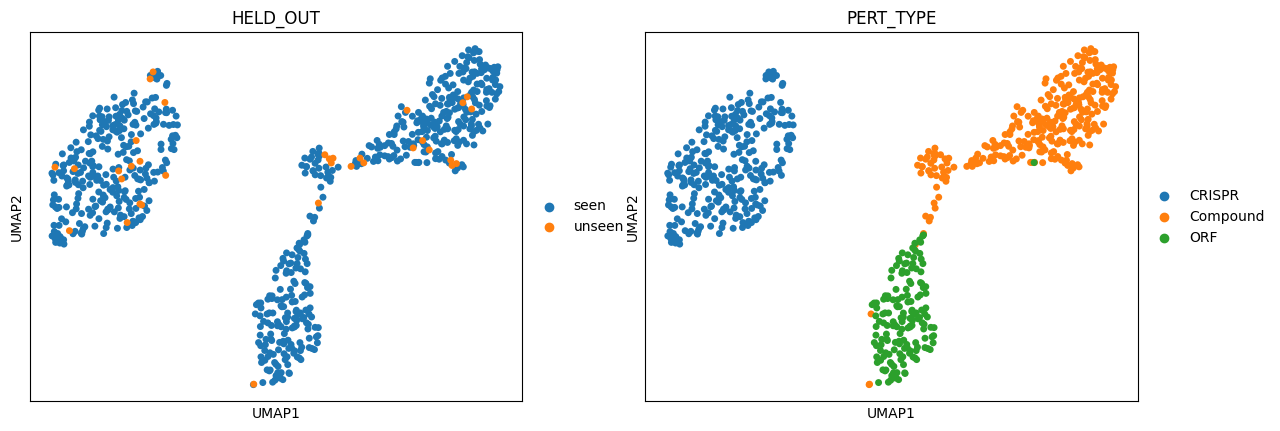

In [19]:
sc.pl.umap(adata, color=["HELD_OUT", "PERT_TYPE"], s=100)

## Plotting intermezzo

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap', 'norm' will be ignored
  cax = scatter(


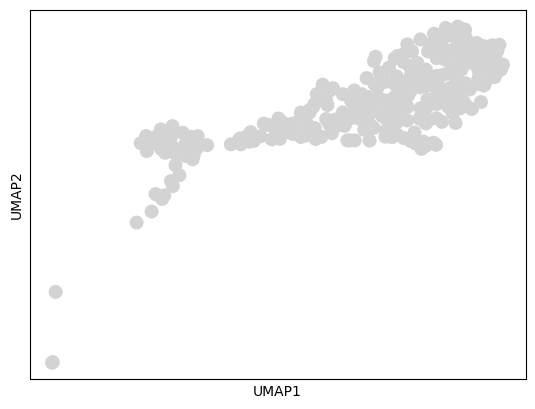

In [20]:
sc.pl.umap(adata[adata.obs.PERT_TYPE=="Compound"], save="umap_crispr.svg")

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


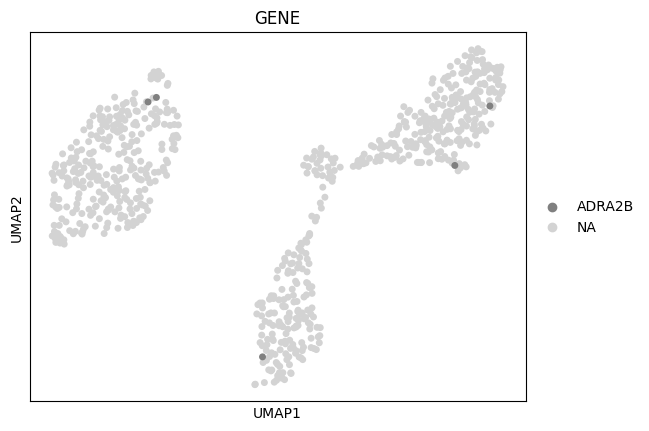

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


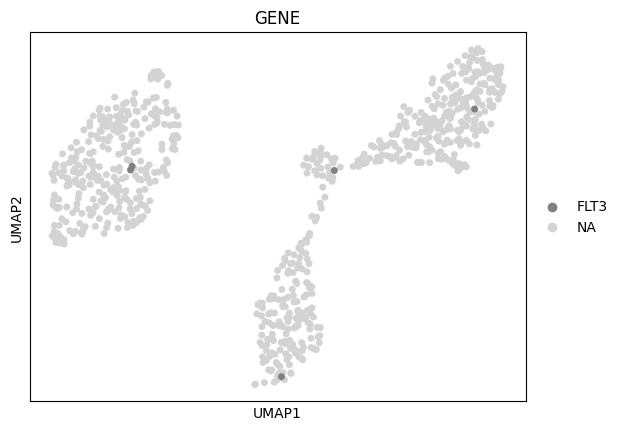

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


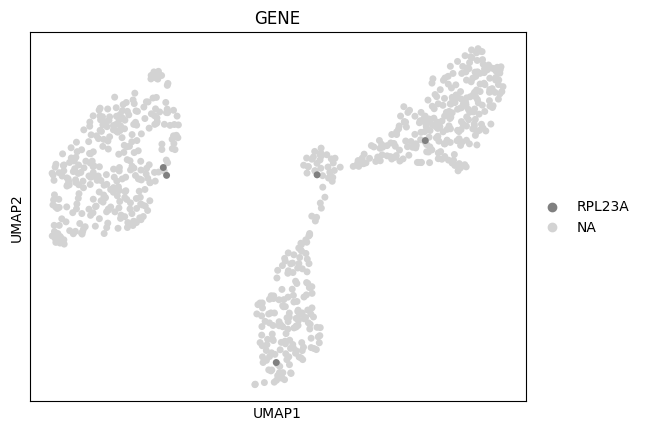

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


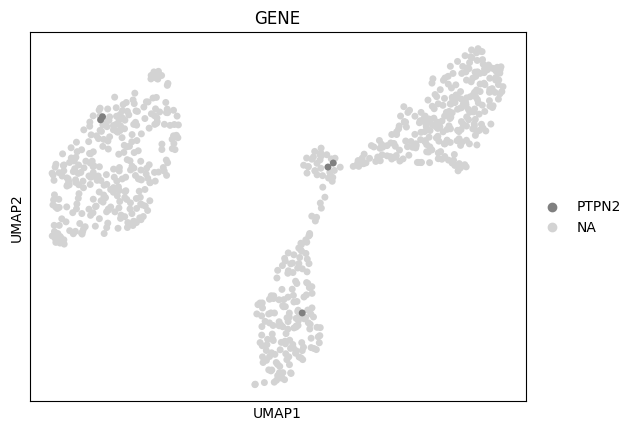

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


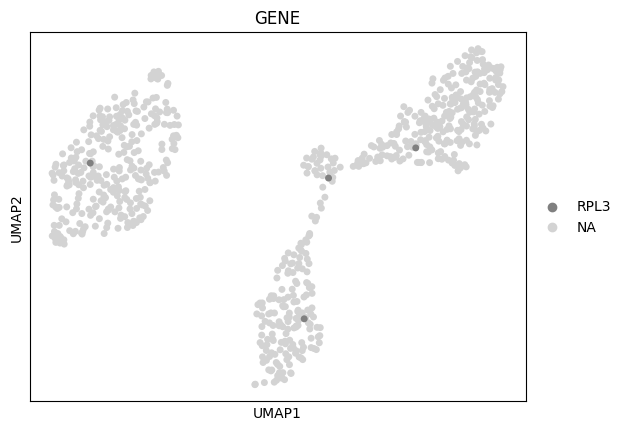

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


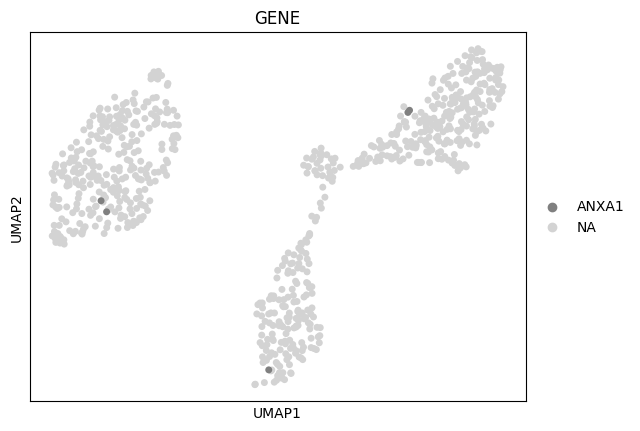

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


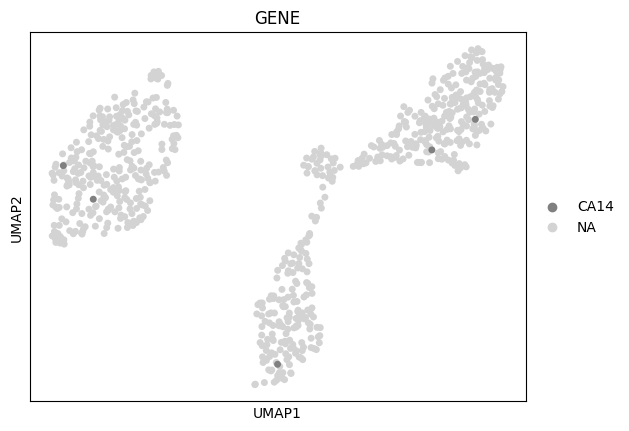

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


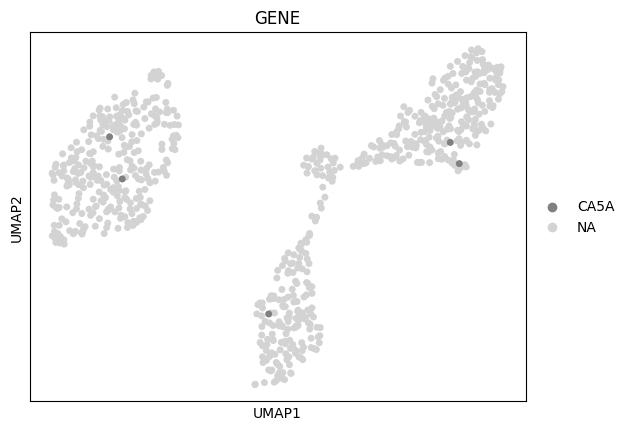

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


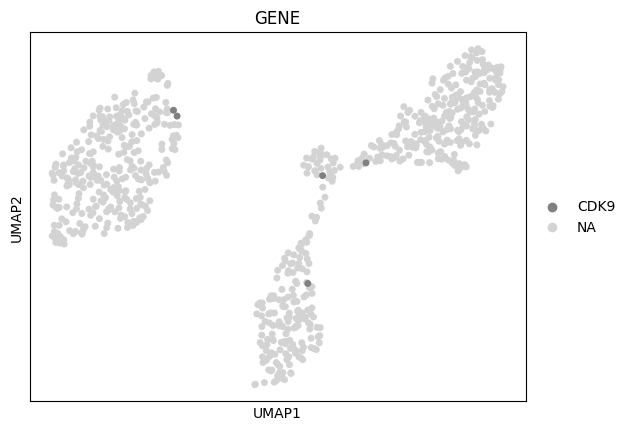

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


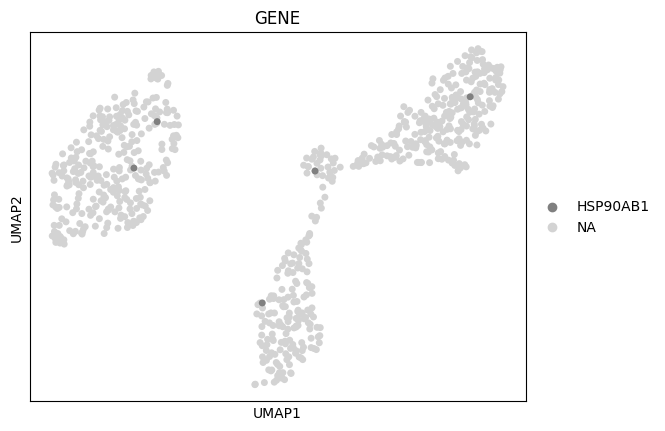

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


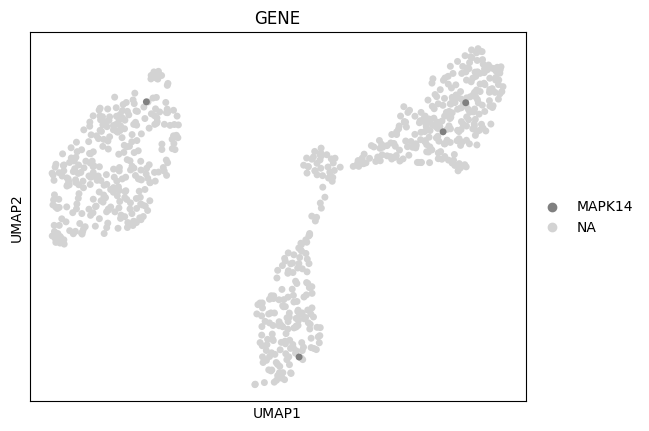

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


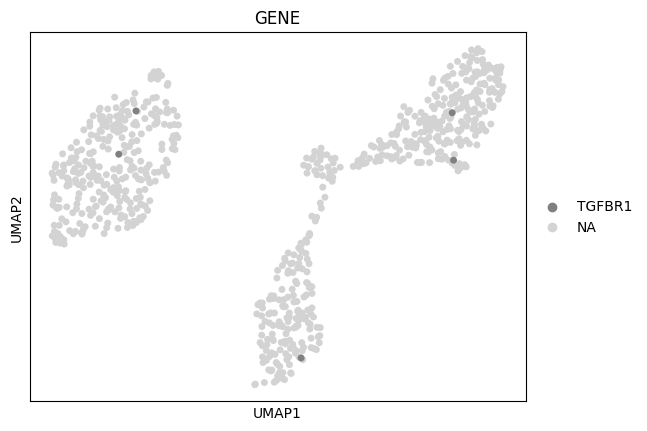

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


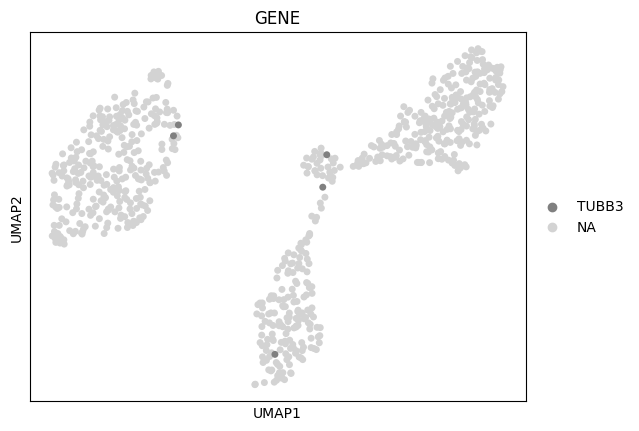

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


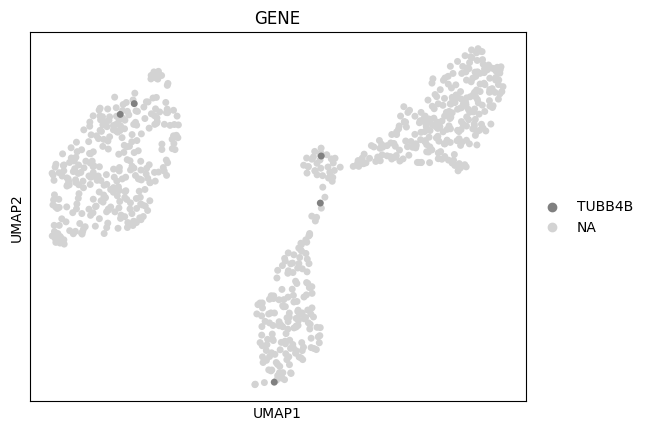

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


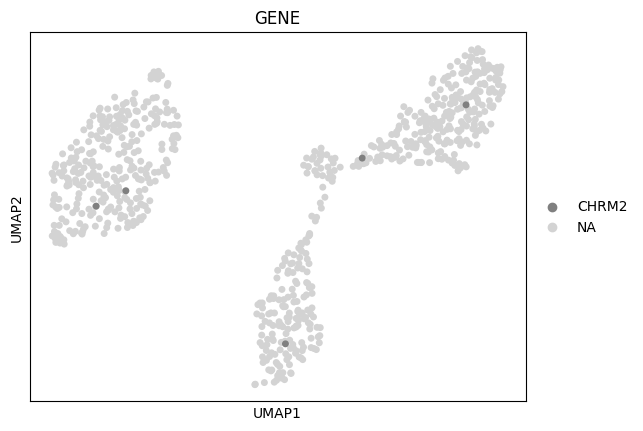

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


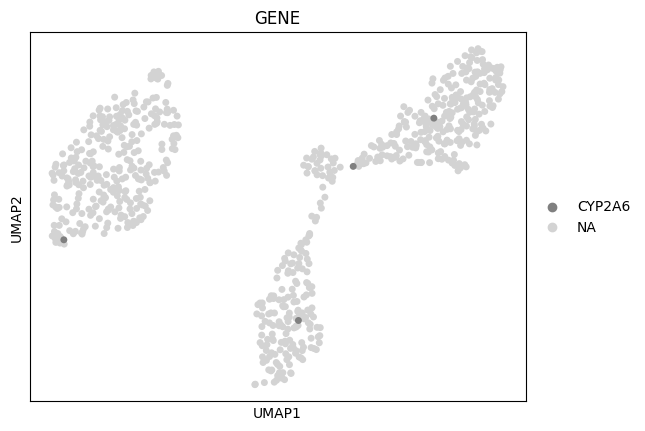

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


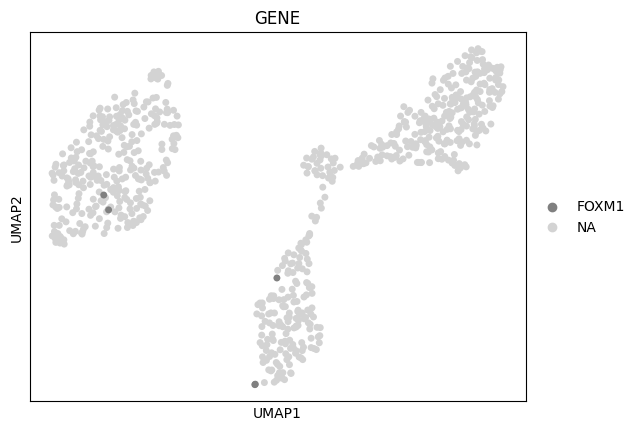

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


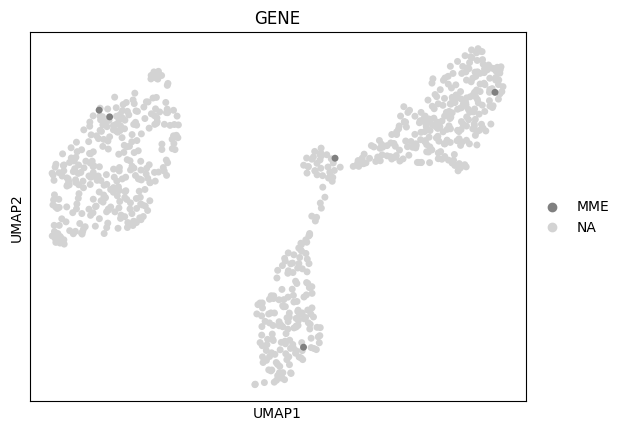

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


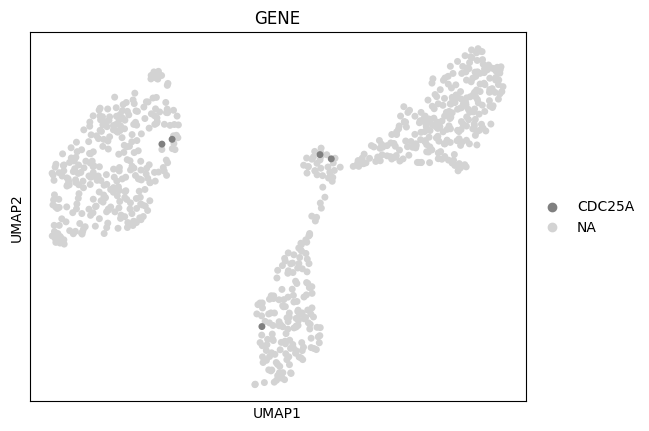

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


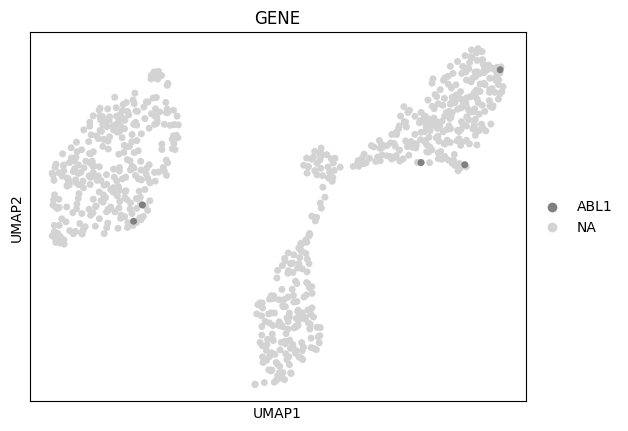

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


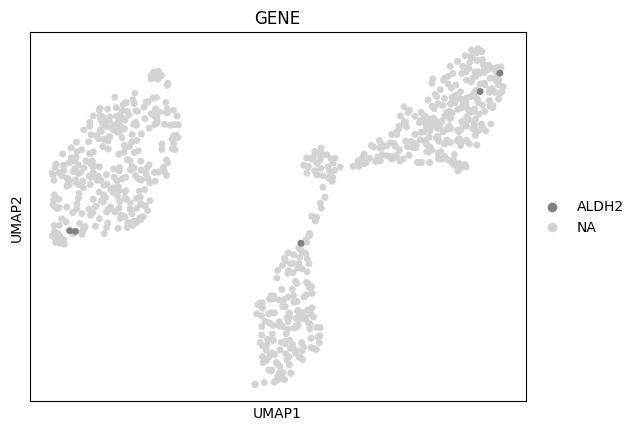

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


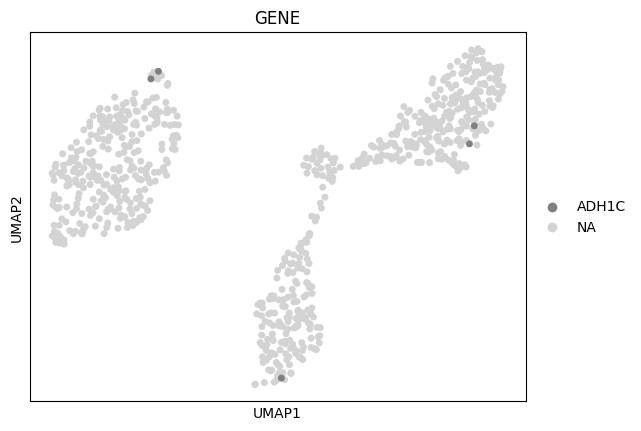

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


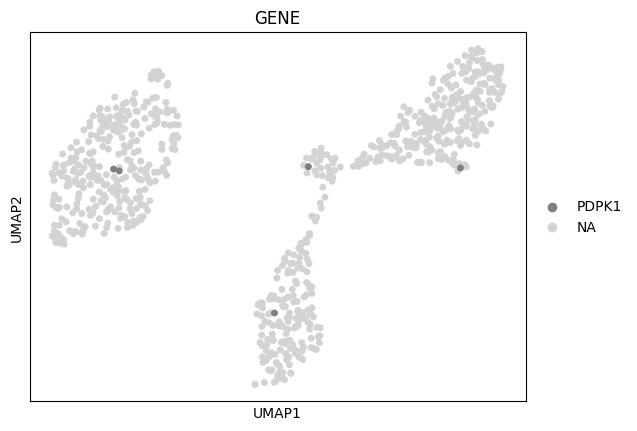

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


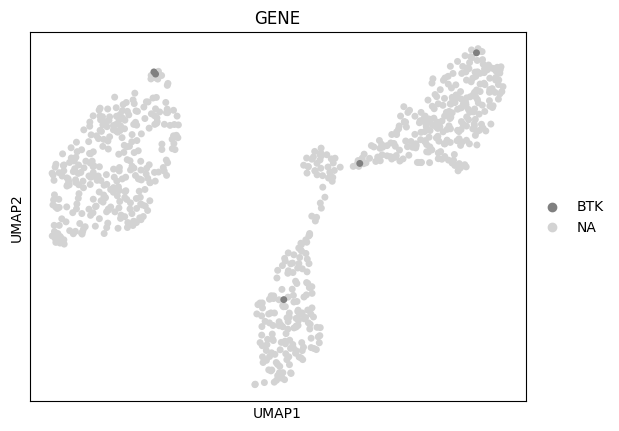

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


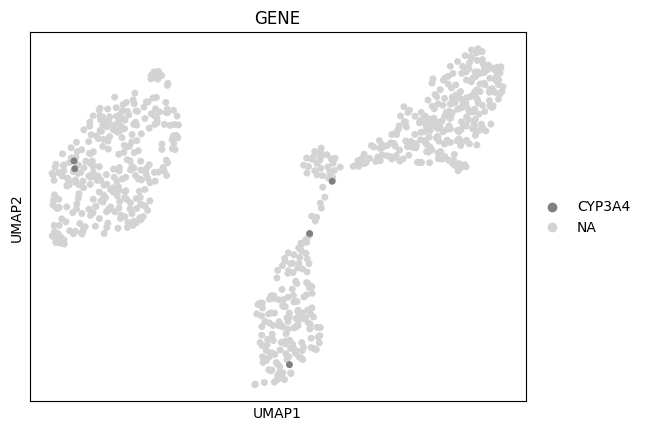

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


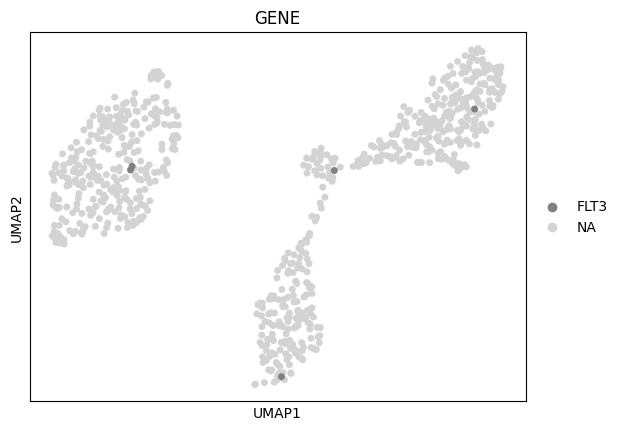

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


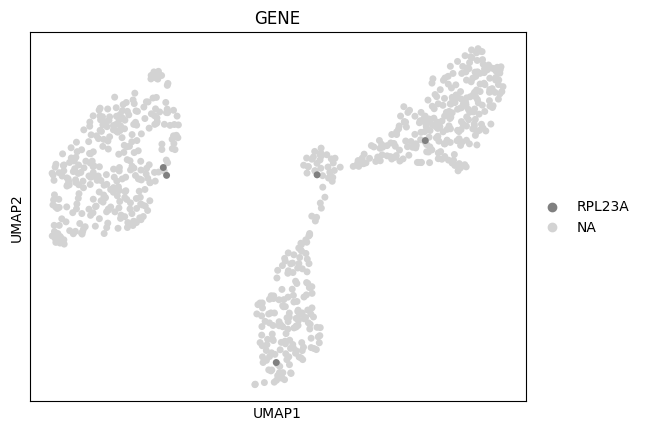

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


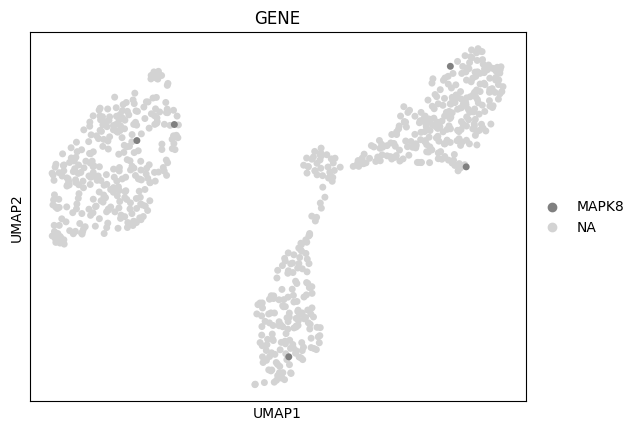

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


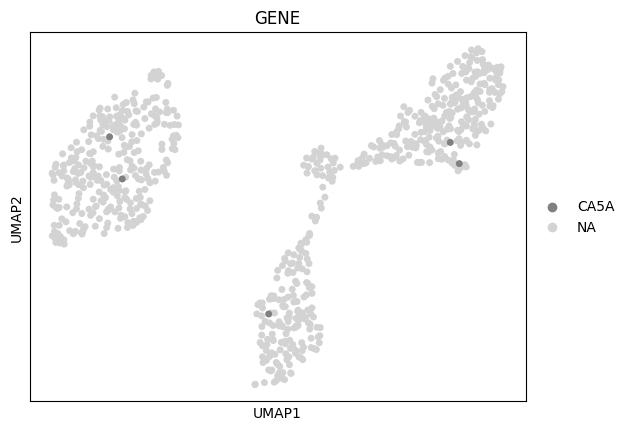

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


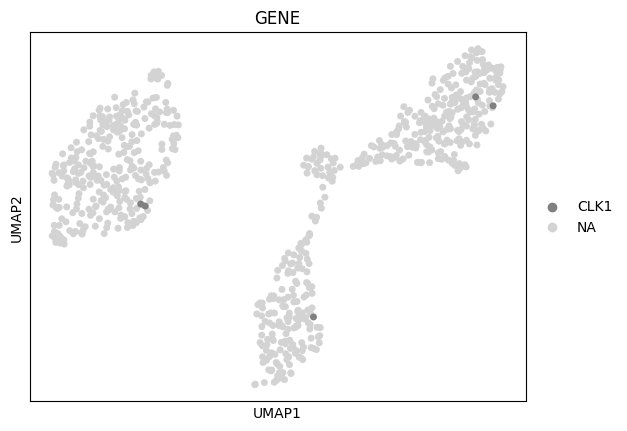

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


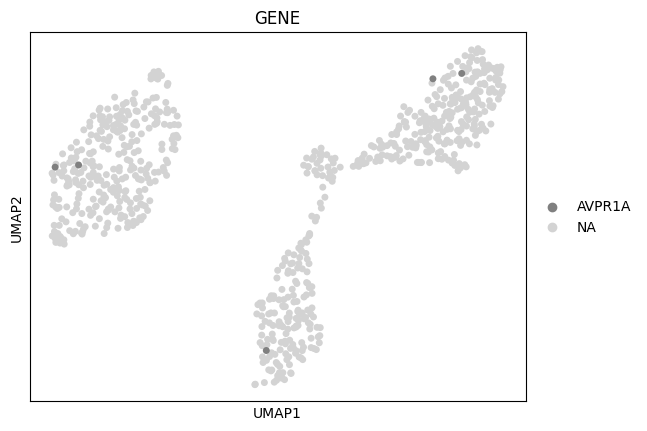

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


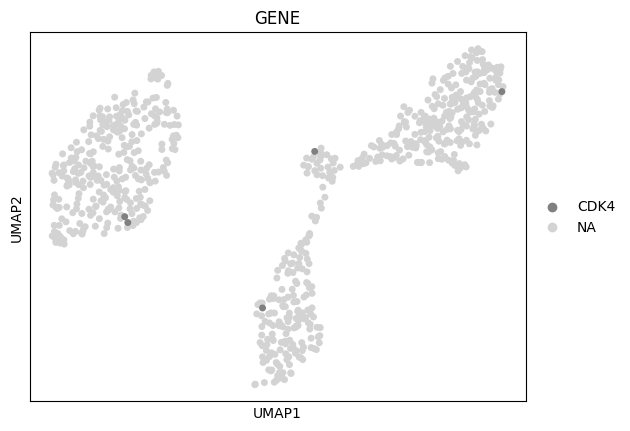

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


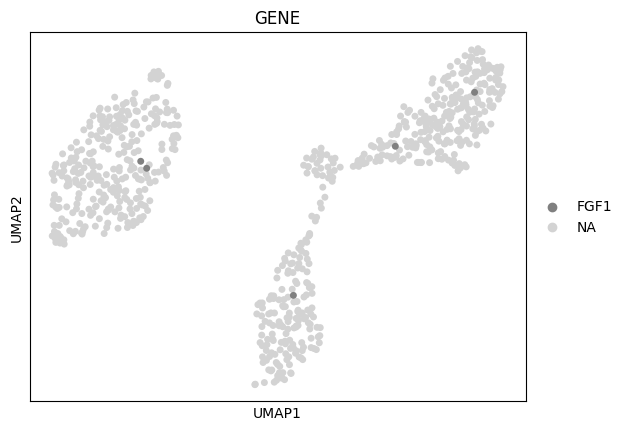

/home/icb/alessandro.palma/miniconda3/envs/IMPA_try/lib/python3.9/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


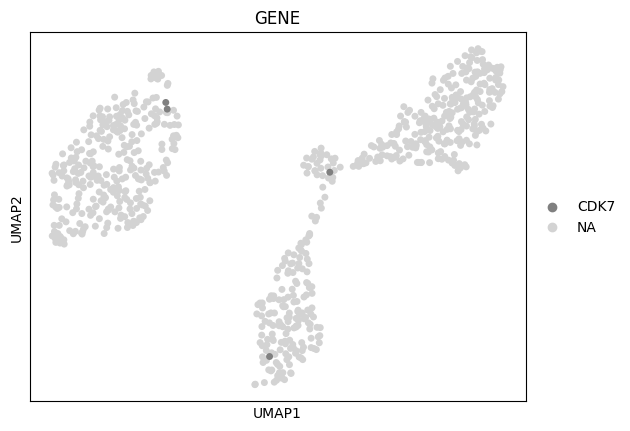

In [21]:
for gene in genes_heldout:
    sc.pl.umap(adata, color="GENE", groups=gene, s=100)